## ライブラリの読み込み

In [90]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import japanize_matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from tqdm import tqdm
import scipy.stats as stats
import math
import matplotlib as mpl
import seaborn as sns
import python_bitbankcc

plt.rcParams['font.size'] = 15

import warnings
warnings.filterwarnings("ignore")

In [91]:
# pip install seaborn

## コードスニペット

### ビットコインデータ取得

In [92]:
def get_data(start,end,pair,candle_type):
    
    #パブリックAPIのオブジェクトを取得
    pub = python_bitbankcc.public()
    
    #引数を日付データに変換
    start_date = datetime.datetime.strptime(start,"%Y%m%d")
    end_date = datetime.datetime.strptime(end,"%Y%m%d")
    
    #日付の引き算
    span = end_date - start_date
    
    #データを入れる配列を定義しておく
    ohlcv_data = []
    
    
    #1時間ごとに時間足データを取得し、結合していく
    for counter in tqdm(range(span.days + 1)):
        
        #日付の計算
        the_day = start_date + datetime.timedelta(days = counter)
        
        #データが欠損している部分は無視する
        try:
            #パブリックAPIのインスタンス化
            value = pub.get_candlestick(pair, candle_type, the_day.strftime("%Y%m%d"))

            #データ部分の抽出
            ohlcv = value["candlestick"][0]['ohlcv']
            
            #結合
            ohlcv_data.extend(ohlcv)
        
        except:
            pass
    
    
    #データフレームに変換
    col = ["Open","High","Low","Close","Volume","Unix Time"]
    df_sum = pd.DataFrame(ohlcv_data, columns = col)
    df_sum['DateTime'] = pd.to_datetime(df_sum['Unix Time'].astype(int), unit='ms')
    df_sum.drop(['Unix Time'], axis=1, inplace=True)
    df_sum.index = df_sum['DateTime']
    df_sum.drop(['DateTime'], axis=1, inplace=True)
    
    return df_sum

### ドルバーの作成

In [93]:
def dollar_bars(df, dv_column, m):
    '''
    ドルバーを計算する
    # 引数
        df: pd.DataFrame()
        column: ドル出来高の列名
        m: int(), 閾値
    # returns
        idx: indexのリスト
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx]

### ラベルの独自性（ユニークネス）の推定

In [116]:
def mp_num_co_events(close_idx, t1, molecule):
    '''
    バーごとの同時発生的な事象の数を計算する
    +molecule[0]はウェイトが計算される最初の日付
    +molecule[-1]はウェイトが計算される最後の日付
    t1[molecule].max()の前に始まる事象は全て計算に影響する
    '''
    #1 期間[molecule[0], molecule[-1]]に及ぶ事象を見つける
    # クローズしていない事象は他のウェイトに影響しなければならない
    t1 = t1.fillna(close_idx[-1])
    # 時点molecule[0]またはその後に終わる事象
    t1 = t1[t1>=molecule[0]]
    # 時点t1[molecule].max()またはその前に始まる事象
    t1 = t1.loc[:t1[molecule].max()]
    
    # バーに及ぶ事象を数える
    iloc = close_idx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=close_idx[iloc[0]:iloc[1]+1])
    for t_in, t_out in t1.iteritems():
        count.loc[t_in:i_out] += 1.
    return count.loc[molecule[0]:t1[molecule].max()]

### ラベルの平均独自性の推定

In [95]:
def mp_sample_tw(t1, num_co_events, molecule):
    # 事象の存続期間にわたる平均独自性を導出する
    weight = pd.Series(index=molecule)
    for t_in, t_out in t1.loc[weight.index].iteritems():
        weight.loc[t_in] = (1./num_co_events.loc[t_in:t_out]).mean()
    return weight

### インディケーター行列の構築

In [96]:
def get_ind_matrix(bar_ix, t1):
    # インディケーター行列を計算する
    ind_m = pd.DataFrame(0, index=bar_ix, columns=range(t1.shape[0]))
    for i, (t0, t1) in enumerate(t1.iteritems()):
        ind_m.loc[t0:t1, i] = 1.
    return ind_m

### 平均独自性の計算

In [97]:
def get_avg_uniqueness(ind_m):
    # インディケーター行列から平均独自性を計算する
    c = ind_m.sum(axis=1) # 同時発生性
    u = ind_m.div(c, axis=0) # 独自性
    avg_u = u[u>0].mean() # 平均独自性
    return avg_u

### 逐次ブートストラップからの抽出

In [98]:
def seq_bootstrap(ind_m, s_length=None):
    # 逐次ブートストラップを通じてサンプルを生成する
    if s_length is None:s_length=ind_m.shape[1]
    phi=[]
    while len(phi)<s_length:
        avg_u=pd.Series()
        for i in ind_m:
            ind_m_=ind_m[phi+[i]] # ind_mを縮める
            avg_u.loc[i]=get_avg_uniquness(ind_m_).iloc[-1]
        prob=avg_u/avg_u.sum() # 抽出確率
        phi+=[np.random.choice(ind_m.columns,p=prob)]
    return phi

### 絶対リターンの帰属による標本ウェイトの決定

In [99]:
def mp_sample_w(t1,num_co_events,close,molecule):
    # リターンの大きさにより標本ウェイトを調整する
    # 加法的にするために対数リターンにする
    ret=np.log(close).diff()
    weight=pd.Series(index=molecule)
    for t_in,t_out in t1.loc[weight.index].iteritems():
        weight.loc[t_in]=(ret.loc[t_in:t_out]/num_co_events.loc[t_in:t_out]).sum()
    return weight.abs()

### 時間減衰ファクターの実装

In [100]:
def get_time_decay(t_w,clf_last_w=1.):
    # 観測された独自性(t_w)に区分線形な減衰を適用する
    # 最も新しい観測値のウェイト=1
    # 最も古い観測値のウェイト=clf_last_w
    clf_w=t_w.sort_index().cumsum()
    if clf_last_w>=0: slope=(1.-clf_last_w)/clf_w.iloc[-1]
    else: slope=1./((clf_last_w+1)*clf_w.iloc[-1])
    const=1.-slope*clf_w.iloc[-1]
    clf_w=const+slope*clf_w
    clf_w[clf_w < 0]=0
    print(const,slope)
    return clf_w

## 逐次ブートストラップの例

In [101]:
def main():
    
    np.random.seed(123)
    # 特徴量の観測値それぞれに対するt0,t1
    t1=pd.Series([2,3,5],index=[0,2,4])
    bar_ix=range(t1.max()+1) # バーのインデックス
    ind_m = get_ind_matrix(bar_ix,t1)
    phi_random=np.random.choice(ind_m.columns,size=ind_m.shape[1])
    print(phi_random)
    print(f'Standard uniqueness: {get_avg_uniqueness(ind_m[phi_random]).mean():.4f}')
    phi_seq = seq_bootstrap(ind_m)
    print(phi_seq)
    print(f'Sequential uniqueness: {get_avg_uniqueness(ind_m[phi_seq]).mean():.4f}')

In [102]:
main()

[2 1 2]
Standard uniqueness: 0.6667
[1, 2, 1]
Sequential uniqueness: 0.6667


## データの取得

In [140]:
start = "20220224" # 4月1日
end = "20220424" # 4月24日
pair = "btc_jpy" # ビットコイン
candle_type = "1hour" # 1分足

df = get_data(start,end,pair,candle_type)

100%|██████████| 60/60 [00:08<00:00,  7.02it/s]


In [141]:
df['dv'] = df['Close'].astype(float) * df['Volume'].astype(float)
print(df.shape)
df.head()

(1440, 6)


,Open,High,Low,Close,Volume,dv
DateTime,,,,,,
2022-02-24 00:00:00,4281951,4299278,4224003,4224003,28.7923,1.216188e+08
2022-02-24 01:00:00,4226558,4234769,4226558,4232770,0.1078,4.562926e+05
2022-02-24 02:00:00,4232771,4259137,4131292,4145490,42.5915,1.765626e+08
2022-02-24 03:00:00,4139532,4143366,4002030,4020002,164.9086,6.629329e+08
2022-02-24 04:00:00,4019703,4049790,3980012,4040741,121.0190,4.890064e+08


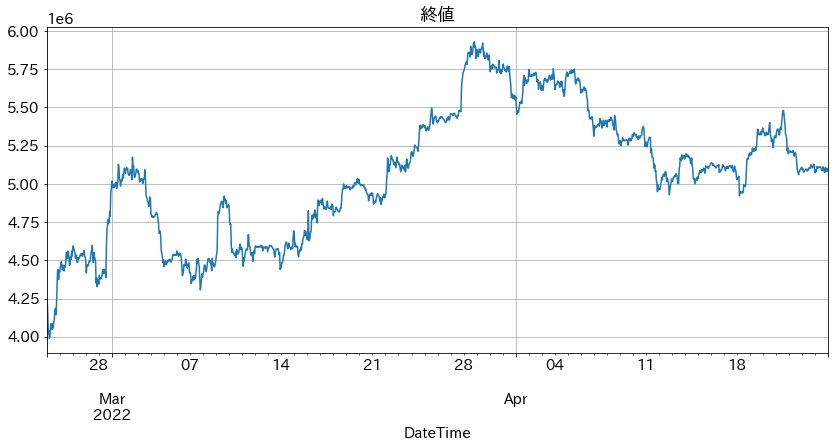

In [142]:
df['Close'].astype(float).plot(figsize=(14, 6))
plt.grid(True)
plt.title('終値')
plt.show()

In [143]:
threshold = 100000000
dollar_bar = dollar_bar_df(df, 'dv', threshold)
print('タイムバー：', df.shape)
print('ドルバー', dollar_bar.shape)

100%|██████████| 1440/1440 [00:00<00:00, 1460652.42it/s]

タイムバー： (1440, 6)
ドルバー (728, 6)


In [144]:
dollar_bar.head()

,Open,High,Low,Close,Volume,dv
DateTime,,,,,,
2022-02-24 00:00:00,4281951,4299278,4224003,4224003,28.7923,1.216188e+08
2022-02-24 02:00:00,4232771,4259137,4131292,4145490,42.5915,1.765626e+08
2022-02-24 03:00:00,4139532,4143366,4002030,4020002,164.9086,6.629329e+08
2022-02-24 04:00:00,4019703,4049790,3980012,4040741,121.0190,4.890064e+08
2022-02-24 05:00:00,4041383,4042979,3963665,3989761,183.2716,7.312099e+08


In [145]:
columns = df.columns
df[columns] = df[columns].astype(float)
columns = dollar_bar.columns
dollar_bar[columns] = dollar_bar[columns].astype(float)

In [146]:
def return_df(df):
    df['PrevClose'] = df['Close'].shift(1)
    df['Return'] = (df['Close'] - df['PrevClose']) / df['PrevClose']
    return df

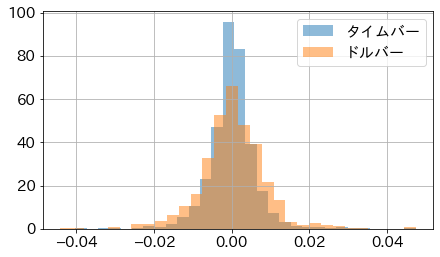

In [147]:
df = return_df(df)
dollar_bar = return_df(dollar_bar)
plt.figure(figsize=(7, 4))
df['Return'].hist(alpha=0.5, label='タイムバー', bins=30, density=True)
dollar_bar['Return'].hist(alpha=0.5, label='ドルバー', bins=30, density=True)
plt.grid(True)
plt.legend()
plt.show()

## ラベル付け

In [148]:
# トリプルバリア法
def triple_barrier(df, take_profit=0.02, stop_loss=0.01, max_holding_period=5):
    prices = df["Close"].values
    label = [0]*len(prices)

    for n in range(len(prices)-max_holding_period):
        outcome = 0
        for m in range(1, max_holding_period):
            if prices[n+m]/prices[n] > 1+take_profit:
                outcome = 1
                break
            if prices[n+m]/prices[n] < 1-stop_loss:
                outcome = -1
                break
        if outcome == 0:
            outcome = 0
        label[n] = outcome
    labels = pd.DataFrame(label, index=df.index, columns=["bin"])

    labels = labels.replace(0.02, 1)
    labels = labels.replace(0.00, 0)
    labels = labels.replace(-0.01, -1)
    
    return labels

In [149]:
labels = triple_barrier(dollar_bar)
labels.value_counts()

bin
 0     400
-1     223
 1     105
dtype: int64

In [151]:
dollar_bar['bin'] = labels

## 重複した結果

In [159]:
count = 0
bins = []
for i in range(dollar_bar.shape[0]-1):
    now = dollar_bar['bin'][i]
    nxt = dollar_bar['bin'][i+1]
    if now == nxt:
        count += 1
        bins.append(now)
print('ラベルの重複数', count)
print('0', bins.count(0))
print('-1', bins.count(-1))
print('1', bins.count(1))
print('=' * 30)
count = 0
for i in range(dollar_bar.shape[0]-1):
    now = dollar_bar['Return'][i]
    nxt = dollar_bar['Return'][i+1]
    if now == nxt:
        count += 1
print('リターンの重複数', count)

ラベルの重複数 546
0 324
-1 154
1 68
リターンの重複数 0


# リターンは重複していないため、終了？